In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import os

DATASET_PATH = '/content/drive/MyDrive/DL/Train'

wav_files = [f for f in os.listdir(DATASET_PATH) if f.endswith(".wav")]
print(f"Total amount .wav files: {len(wav_files)}")


Total amount .wav files: 3166


In [43]:
!pip install librosa

4f_7142.wav: 144725 samples, sample rate = 16000


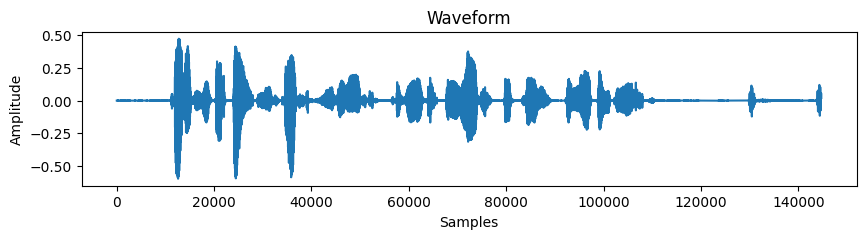

In [44]:
import librosa
import matplotlib.pyplot as plt

file_path = os.path.join(DATASET_PATH, wav_files[0])

#Loading audio at fixed sample rate (16kHz)
signal, sr = librosa.load(file_path, sr=16000)
print(f"{wav_files[0]}: {len(signal)} samples, sample rate = {sr}")

plt.figure(figsize=(10, 2))
plt.plot(signal)
plt.title("Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

In [50]:
import os
import librosa
import numpy as np
from tqdm import tqdm

#Initialising the training dateset, listing audiofiles in directory and defining audio settings:
DATASET_PATH = '/content/drive/MyDrive/DL/Train'
audio_filenames = [file for file in os.listdir(DATASET_PATH) if file.endswith(".wav")]

SAMPLE_RATE = 16000
FIXED_RAW_LENGTH = 64000  # 4 seconds of audio at 16kHz

def preprocess_raw_audio(audio_signal):
  """
  Function to preprocess raw audio waveform by:
    - padding or truncating to fixed values
    - normalizing the signal
  """
  if len(audio_signal) < FIXED_RAW_LENGTH:
      padding_amount = FIXED_RAW_LENGTH - len(audio_signal)
      audio_signal = np.pad(audio_signal, (0, padding_amount))
  else:
      audio_signal = audio_signal[:FIXED_RAW_LENGTH]
  normalized_signal = (audio_signal - np.mean(audio_signal)) / np.std(audio_signal)
  return normalized_signal

def convert_to_mel_spectrogram(audio_signal, sample_rate):
  """
  Function to covert raw audio waveform to Mel Spectograms by:
    - librosa Mel spectogram (64 Mel bins)
    - converting to decibel scale for better range
  """
  mel_spectrogram = librosa.feature.melspectrogram(
      y=audio_signal,
      sr=sample_rate,
      n_fft=1024,
      hop_length=512,
      n_mels=64
  )
  mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
  return mel_spectrogram_db

#Lists to hold preprocessed data
raw_audio_dataset = []
mel_spectrogram_dataset = []

#Loading, preprocessing and storing of the preprocessed data in the lists
for audio_filename in tqdm(audio_filenames):
  full_file_path = os.path.join(DATASET_PATH, audio_filename)
  audio_signal, sample_rate = librosa.load(full_file_path, sr=SAMPLE_RATE)

  raw_audio = preprocess_raw_audio(audio_signal)
  mel_spectrogram = convert_to_mel_spectrogram(audio_signal, sample_rate)

  raw_audio_dataset.append(raw_audio)
  mel_spectrogram_dataset.append(mel_spectrogram)

100%|██████████| 3166/3166 [00:46<00:00, 67.90it/s] 


In [51]:
print (len(raw_audio_dataset))
print( len(mel_spectrogram_dataset))

print( raw_audio_dataset[0].shape)
print(mel_spectrogram_dataset[0].shape)

3166
3166
(64000,)
(64, 283)


In [52]:
import torch

#Determining maximum length for the mel spectograms to be the same width
maximum_spectrogram_length = max([spectrogram.shape[1] for spectrogram in mel_spectrogram_dataset])

#Function to pad Mel spectogram to taget length along the time axis
def pad_mel_spectrogram(spectrogram, target_length):
    if spectrogram.shape[1] < target_length:
        padding_amount = target_length - spectrogram.shape[1]
        return np.pad(spectrogram, ((0, 0), (0, padding_amount))) #Padding only the time axis
    return spectrogram

#Pad all spectograms in the dataset to the same length
padded_mel_spectrograms = [pad_mel_spectrogram(spectrogram, maximum_spectrogram_length) for spectrogram in mel_spectrogram_dataset]

#Convert to torch tensor for training and add channel dimension to match the transformer imput shape
X_mel_spectrogram = torch.tensor(np.array(padded_mel_spectrograms), dtype=torch.float32).unsqueeze(1)
print("Vorm van X_mel_spectrogram:", X_mel_spectrogram.shape)


Vorm van X_mel_spectrogram: torch.Size([3166, 1, 64, 406])


In [53]:
#Determines the maximum length of raw audio signals in dataset
maximum_raw_audio_length = max([len(audio_signal) for audio_signal in raw_audio_dataset])

# Function to pad a raw audio signal to the target length by padding with zeros at the end if audio is too short
def pad_raw_audio(audio_signal, target_length):
    if len(audio_signal) < target_length:
        return np.pad(audio_signal, (0, target_length - len(audio_signal)))
    return audio_signal

#Pad all raw audio to the maximum length
padded_raw_audio = [pad_raw_audio(audio_signal, maximum_raw_audio_length) for audio_signal in raw_audio_dataset]

# Convert to a PyTorch tensor for training and add channel dimension (unsqueeze at axis 1) to match input shape expected by models
X_raw_audio = torch.tensor(np.array(padded_raw_audio), dtype=torch.float32).unsqueeze(1)
print("Vorm van X_raw_audio:", X_raw_audio.shape)

Vorm van X_raw_audio: torch.Size([3166, 1, 64000])


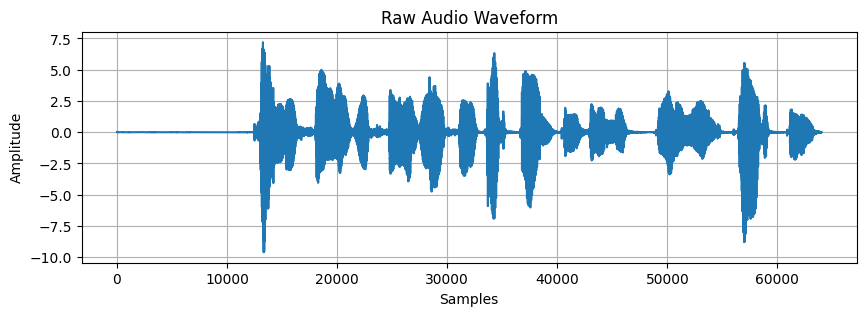

In [54]:
import matplotlib.pyplot as plt

#Randomly choosing an index to visualise the raw audio waveform, extracting data and coverting tensor to numpy array
index = 13
raw_sample = X_raw_audio[index].squeeze().numpy()

#Display visualisation
plt.figure(figsize=(10, 3))
plt.plot(raw_sample)
plt.title("Raw Audio Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

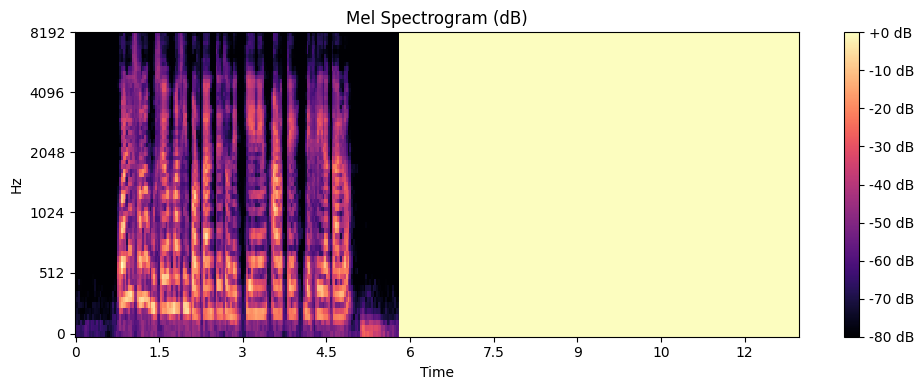

In [55]:
import librosa.display

#Randomly selecting an index to visualise the Mel spectogram
mel_sample = X_mel_spectrogram[index].squeeze().numpy()  # shape: [64, 406]

#Displaying visualisation
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_sample, sr=16000, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram (dB)")
plt.tight_layout()
plt.show()

In [56]:
import pandas as pd
index = 14  #random again

# Raw audio as table
raw_sample_array = X_raw_audio[index].squeeze().numpy()
raw_audio_table = pd.DataFrame(raw_sample_array, columns=["Amplitude"])
print(raw_audio_table.head(10))

# Mel spectrogram as table
mel_sample_array = X_mel_spectrogram[index].squeeze().numpy()
mel_spectrogram_table = pd.DataFrame(mel_sample_array)
print(mel_spectrogram_table.head(10))

   Amplitude
0   0.005070
1   0.001996
2   0.002764
3   0.002380
4   0.001996
5   0.001611
6   0.001611
7   0.001996
8   0.002764
9   0.001227
         0          1          2          3          4          5    \
0 -70.720108 -71.061462 -67.725388 -67.929062 -61.183098 -64.800629   
1 -69.684937 -70.860901 -69.190468 -69.504013 -73.660606 -59.908615   
2 -75.825882 -74.125259 -68.432167 -69.553436 -73.415710 -62.414917   
3 -79.817627 -72.792305 -79.275192 -66.545738 -75.782532 -76.442093   
4 -79.051254 -76.388245 -77.343979 -71.880157 -78.051384 -74.915916   
5 -80.000000 -73.556351 -80.000000 -78.313530 -76.952072 -77.292114   
6 -80.000000 -79.699814 -80.000000 -80.000000 -78.047852 -80.000000   
7 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
8 -79.889008 -80.000000 -80.000000 -80.000000 -80.000000 -79.769913   
9 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -77.685059   

         6          7          8          9    ...  396  397  398  399  400

First model -> Transformer

In [58]:
import torch
import torch.nn as nn

class SpectrogramTransformer(nn.Module):
  """
  Transformer based model for the Mel spectograms.
    - Takes Mel features,
    - Applies linear projection, positional encoding and Transformer Encoder
    - Outputs logits for each class
  """
  def __init__(self, input_dim=64, model_dim=128, num_heads=4, num_layers=2, num_classes=5, max_seq_len=500, dropout=0.1):
    super(SpectrogramTransformer, self).__init__()

    self.input_proj = nn.Linear(input_dim, model_dim)
    self.positional_encoding = nn.Parameter(torch.randn(1, max_seq_len, model_dim))

    encoder_layer = nn.TransformerEncoderLayer(
        d_model=model_dim,
        nhead=num_heads,
        dim_feedforward=256,
        dropout=dropout,
        batch_first=True
    )
    self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    self.dropout = nn.Dropout(dropout)  # Dropout for regularisation
    self.classifier = nn.Linear(model_dim, num_classes)

  def forward(self, x):
    """
    Forward passing function for the model, that takes input Mel spectogram and returns the class logits.
      - Linear projects model dimension
      - Adds positional encoding
      - Passes through transformer encoder
      - Applies global average pooling
      - Applies dropout
      - Outputs final classsification layer
    """
    x = self.input_proj(x)
    x = x + self.positional_encoding[:, :x.size(1), :]
    x = self.encoder(x)
    x = x.mean(dim=1)
    x = self.dropout(x)
    return self.classifier(x)

In [60]:
#Model initiation and parameter checking for troubleshooting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpectrogramTransformer(model_dim=256, num_heads=8, num_layers=4).to(device)

params = list(model.parameters())
print(f"Total trainable parameters: {len(params)}")
for name, param in model.named_parameters():
    print(name, param.shape)

Total trainable parameters: 53
positional_encoding torch.Size([1, 500, 256])
input_proj.weight torch.Size([256, 64])
input_proj.bias torch.Size([256])
encoder.layers.0.self_attn.in_proj_weight torch.Size([768, 256])
encoder.layers.0.self_attn.in_proj_bias torch.Size([768])
encoder.layers.0.self_attn.out_proj.weight torch.Size([256, 256])
encoder.layers.0.self_attn.out_proj.bias torch.Size([256])
encoder.layers.0.linear1.weight torch.Size([256, 256])
encoder.layers.0.linear1.bias torch.Size([256])
encoder.layers.0.linear2.weight torch.Size([256, 256])
encoder.layers.0.linear2.bias torch.Size([256])
encoder.layers.0.norm1.weight torch.Size([256])
encoder.layers.0.norm1.bias torch.Size([256])
encoder.layers.0.norm2.weight torch.Size([256])
encoder.layers.0.norm2.bias torch.Size([256])
encoder.layers.1.self_attn.in_proj_weight torch.Size([768, 256])
encoder.layers.1.self_attn.in_proj_bias torch.Size([768])
encoder.layers.1.self_attn.out_proj.weight torch.Size([256, 256])
encoder.layers.1.s

In [61]:
from torch.utils.data import TensorDataset, DataLoader

X_mel = X_mel_spectrogram.squeeze(1).permute(0, 2, 1)
y = torch.tensor([int(f[0]) - 1 for f in audio_filenames])

# Dataset and loader
dataset = TensorDataset(X_mel, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training setup
model = SpectrogramTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 100
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f} | Accuracy: {acc:.2f}%")

Epoch 1/100 | Loss: 157.5964 | Accuracy: 26.60%
Epoch 2/100 | Loss: 151.7903 | Accuracy: 32.28%
Epoch 3/100 | Loss: 139.5926 | Accuracy: 39.01%
Epoch 4/100 | Loss: 132.3320 | Accuracy: 41.00%
Epoch 5/100 | Loss: 125.6825 | Accuracy: 45.36%
Epoch 6/100 | Loss: 124.8744 | Accuracy: 45.61%
Epoch 7/100 | Loss: 115.1365 | Accuracy: 50.41%
Epoch 8/100 | Loss: 108.2225 | Accuracy: 54.11%
Epoch 9/100 | Loss: 102.7418 | Accuracy: 55.94%
Epoch 10/100 | Loss: 100.4375 | Accuracy: 57.49%
Epoch 11/100 | Loss: 92.3629 | Accuracy: 61.59%
Epoch 12/100 | Loss: 86.8635 | Accuracy: 64.31%
Epoch 13/100 | Loss: 80.2658 | Accuracy: 68.89%
Epoch 14/100 | Loss: 76.4719 | Accuracy: 68.70%
Epoch 15/100 | Loss: 70.8995 | Accuracy: 71.95%
Epoch 16/100 | Loss: 68.7804 | Accuracy: 71.86%
Epoch 17/100 | Loss: 66.0192 | Accuracy: 74.19%
Epoch 18/100 | Loss: 60.2723 | Accuracy: 76.31%
Epoch 19/100 | Loss: 55.3051 | Accuracy: 78.46%
Epoch 20/100 | Loss: 54.6195 | Accuracy: 78.27%
Epoch 21/100 | Loss: 50.1886 | Accuracy

In [62]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

#Splitting train (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_mel, y, test_size=0.2, random_state=42, stratify=y)

#Creating dataloaders for model training with shuffling for the training loader for randomisation
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)

In [63]:
#Creating the tensors, training and validation sets for gender and accent statistical analysis
accent_labels = [int(f[0]) - 1 for f in audio_filenames]
gender_labels = [0 if f[1] == 'm' else 1 for f in audio_filenames]  # 0 = male, 1 = female

accent_labels = torch.tensor(accent_labels)
gender_labels = torch.tensor(gender_labels)

_, accent_val = train_test_split(accent_labels, test_size=0.2, random_state=42, stratify=accent_labels)
_, gender_val = train_test_split(gender_labels, test_size=0.2, random_state=42, stratify=gender_labels)

In [64]:
from sklearn.metrics import accuracy_score
import numpy as np

def evaluate(model, val_loader, accent_val, gender_val):
  """
  Evaluates the trained model on the validation set through overall accuracy,
  accuracy for accent and, for troubleshooting, gender.
  """
  model.eval()
  all_preds = []
  all_targets = []

  with torch.no_grad():
    for inputs, targets in val_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      preds = outputs.argmax(dim=1)
      all_preds.extend(preds.cpu().numpy())
      all_targets.extend(targets.cpu().numpy())

  all_preds = np.array(all_preds)
  all_targets = np.array(all_targets)
  accent_val = accent_val.numpy()
  gender_val = gender_val.numpy()

  overall_acc = accuracy_score(all_targets, all_preds)

  print("\n Accuracy per Accent:")
  for accent in np.unique(accent_val):
    indices = np.where(accent_val == accent)[0]
    acc = accuracy_score(all_targets[indices], all_preds[indices])
    print(f"Accent {accent + 1}: {acc * 100:.2f}%")

  print("\n Accuracy per Gender:")
  for g in [0, 1]:
    label = "Male" if g == 0 else "Female"
    indices = np.where(gender_val == g)[0]
    acc = accuracy_score(all_targets[indices], all_preds[indices])
    print(f"{label}: {acc * 100:.2f}%")

  print(f"\n Overall Accuracy: {overall_acc * 100:.2f}%")
  model.train()

In [65]:
evaluate(model, val_loader, accent_val, gender_val)


 Accuracy per Accent:
Accent 1: 100.00%
Accent 2: 100.00%
Accent 3: 98.23%
Accent 4: 99.34%
Accent 5: 98.97%

 Accuracy per Gender:
Male: 99.67%
Female: 99.09%

 Overall Accuracy: 99.37%


In [66]:
import random
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

#Audio data augmentation transforms
time_mask = T.TimeMasking(time_mask_param=15)  #masks out random temporal segments
freq_mask = T.FrequencyMasking(freq_mask_param=5)  # masks out random frequency bands

#Adds noise to tensor
def add_noise(mel_spec, noise_level=0.003):
    noise = torch.randn_like(mel_spec) * noise_level
    return mel_spec + noise

#Applies the augmentations and noise
def apply_augmentations(mel_spec_tensor):
    if random.random() < 0.7:
        mel_spec_tensor = time_mask(mel_spec_tensor)
    if random.random() < 0.7:
        mel_spec_tensor = freq_mask(mel_spec_tensor)
    if random.random() < 0.5:
        mel_spec_tensor = add_noise(mel_spec_tensor)
    return mel_spec_tensor

#Custom dataset class for applying the augmentation during training and delaying augmentation for later epochs for stability
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, augment=False, delay_aug_epochs=0, mix_prob=0.5):
        self.X = X
        self.y = y
        self.augment = augment
        self.delay_aug_epochs = delay_aug_epochs
        self.mix_prob = mix_prob
        self.current_epoch = 0

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        #Applying aug. conditionally
        if self.augment and self.current_epoch >= self.delay_aug_epochs:
            if random.random() < self.mix_prob:
                x = apply_augmentations(x.unsqueeze(0)).squeeze(0)

        return x, y

    def __len__(self):
        return len(self.y)

#Updating the current epoch
    def set_epoch(self, epoch):
        self.current_epoch = epoch
#Creating the training for aug. after delay, no augmentation and validation sets
train_dataset_aug = AudioDataset(
    X_train,
    y_train,
    augment=True,
    delay_aug_epochs=5,
    mix_prob=0.5
)
train_dataset_no_aug = AudioDataset(X_train, y_train, augment=False)
val_dataset = AudioDataset(X_val, y_val, augment=False)

#Dataloaders for the above sets
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)
train_loader_no_aug = DataLoader(train_dataset_no_aug, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [67]:
from sklearn.metrics import accuracy_score

def train_model(model, train_dataset, val_loader, accent_val, gender_val, label=""):
  """
  Training function for the current version of the model
  using with 100 epochs
  """
  train_loss_log, val_acc_log = [], []

  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  criterion = torch.nn.CrossEntropyLoss()  # for classification
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Adam optimiser for mininmising loss

  for epoch in range(100):
    model.train()
    train_dataset.set_epoch(epoch)

    total_loss = 0
    correct = 0
    total = 0

    # Training loop
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)  # forward pass
      loss = criterion(outputs, targets)
      loss.backward()  # backpropagation and optimisation
      optimizer.step()

      # Updating metrics
      total_loss += loss.item()
      preds = outputs.argmax(dim=1)
      correct += (preds == targets).sum().item()
      total += targets.size(0)

    train_acc = correct / total * 100
    train_loss_log.append(total_loss)

    # Evaluation on validation
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
      for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    val_acc = accuracy_score(all_targets, all_preds) * 100
    val_acc_log.append(val_acc)

    # Printing validation metrics
    print(f"{label} | Epoch {epoch+1}: Train Loss={total_loss:.4f}, "
          f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

  return train_loss_log, val_acc_log

# Training without augmentation
model_no_aug = SpectrogramTransformer().to(device)
loss_no_aug, acc_no_aug = train_model(model_no_aug, train_dataset_no_aug, val_loader, accent_val, gender_val, label="No Aug")

# Training with augmentation
model_aug = SpectrogramTransformer().to(device)
loss_aug, acc_aug = train_model(model_aug, train_dataset_aug, val_loader, accent_val, gender_val, label="With Aug")

No Aug | Epoch 1: Train Loss=127.7541, Train Acc=25.00%, Val Acc=29.02%
No Aug | Epoch 2: Train Loss=126.5954, Train Acc=26.97%, Val Acc=29.18%
No Aug | Epoch 3: Train Loss=125.4646, Train Acc=30.41%, Val Acc=30.28%
No Aug | Epoch 4: Train Loss=123.7631, Train Acc=31.36%, Val Acc=31.86%
No Aug | Epoch 5: Train Loss=121.8088, Train Acc=33.85%, Val Acc=38.33%
No Aug | Epoch 6: Train Loss=116.8409, Train Acc=37.80%, Val Acc=31.86%
No Aug | Epoch 7: Train Loss=109.3334, Train Acc=40.60%, Val Acc=43.85%
No Aug | Epoch 8: Train Loss=104.0783, Train Acc=43.05%, Val Acc=41.96%
No Aug | Epoch 9: Train Loss=100.0715, Train Acc=46.01%, Val Acc=45.43%
No Aug | Epoch 10: Train Loss=94.3500, Train Acc=47.95%, Val Acc=48.58%
No Aug | Epoch 11: Train Loss=93.0709, Train Acc=49.76%, Val Acc=53.31%
No Aug | Epoch 12: Train Loss=88.0780, Train Acc=52.29%, Val Acc=54.26%
No Aug | Epoch 13: Train Loss=85.2117, Train Acc=55.73%, Val Acc=38.80%
No Aug | Epoch 14: Train Loss=86.5250, Train Acc=53.20%, Val Acc

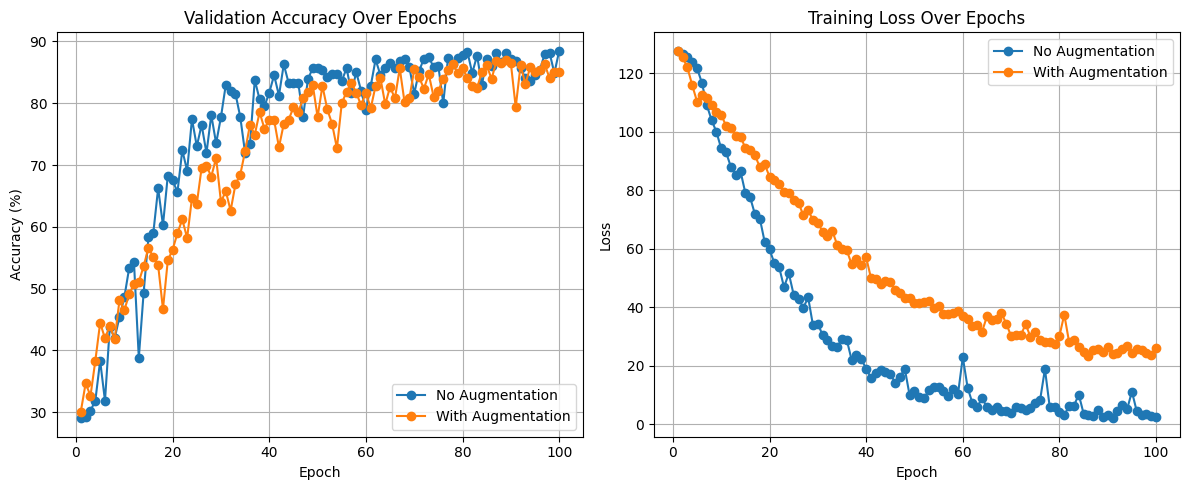

In [68]:
import matplotlib.pyplot as plt


#Visualisation to check the analysis and ensuring no model overfitting
epochs = list(range(1, len(acc_no_aug) + 1))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc_no_aug, label='No Augmentation', marker='o')
plt.plot(epochs, acc_aug, label='With Augmentation', marker='o')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_no_aug, label='No Augmentation', marker='o')
plt.plot(epochs, loss_aug, label='With Augmentation', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Model for the Raw Audio Files (Model 2) -> RNN

In [69]:
#The RNN model and the augmentation functions

def add_noise(audio, noise_level=0.005):   #Adding noise to the raw audio and the control for the noise
    noise = torch.randn_like(audio) * noise_level
    return audio + noise

def time_shift(audio, shift_limit=0.1):   #Applying random time shift
    shift = int(random.uniform(-shift_limit, shift_limit) * audio.shape[-1])
    return torch.roll(audio, shifts=shift, dims=-1) #cyclically shifting the data form

def volume_change(audio, gain_range=(0.8, 1.2)):  #Randomly adjusts amplitude of audio signal and gain scales
    gain = random.uniform(*gain_range)
    return audio * gain

#Custon dataset for raw audio data that supports augmentation and frames waveform for RNN input
class RawAudioDataset(Dataset):
    def __init__(self, X_raw, y, augment=False, delay_aug_epochs=0, mix_prob=0.5):
        self.X = X_raw
        self.y = y
        self.augment = augment
        self.delay_aug_epochs = delay_aug_epochs
        self.mix_prob = mix_prob
        self.current_epoch = 0

    def __getitem__(self, idx):  #Get audio sample, apply aug. if aug. enabled and delay condition is met
        x = self.X[idx].squeeze(0)
        y = self.y[idx]

        #Conditional augmentation
        if self.augment and self.current_epoch >= self.delay_aug_epochs:
            if random.random() < self.mix_prob:
                if random.random() < 0.7:
                    x = add_noise(x)
                if random.random() < 0.5:
                    x = time_shift(x)
                if random.random() < 0.3:
                    x = volume_change(x)

        x = x.unfold(0, 400, 160) #Frame raw waveform
        return x, y

    def __len__(self):
        return len(self.y)

    def set_epoch(self, epoch):  #Updating current epoch for delayed augmentation start
        self.current_epoch = epoch

In [70]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

#Prepare the raw dataset for RNN
X_raw_audio_rnn = X_raw_audio.squeeze(1)
X_rnn = X_raw_audio_rnn.unfold(dimension=1, size=400, step=160)

#Training and Validation splits
indices = np.arange(len(y))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=42)

#Validation dataset (with no augmentation) and validation loader
val_dataset_raw = RawAudioDataset(X_raw_audio, y, augment=False)
val_loader_raw = DataLoader(Subset(val_dataset_raw, val_idx), batch_size=32, shuffle=False)

class Raw_RNN(nn.Module):
    """
    Bidirectional GRU based RNN model that takes raw waveform as input and outputs the class logits
    """
    def __init__(self, input_dim=400, hidden_dim=128, num_layers=2, num_classes=5, dropout=0.3):
        super(Raw_RNN, self).__init__()   #Initialising the GRU layers with dropout
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim,
                          num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)  #Dropout layer before classification
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)  #Final linear layer that maps hidden states to output logits

    def forward(self, x):
        rnn_out, _ = self.rnn(x)   #GRU forward
        pooled = rnn_out.mean(dim=1)  #Global average pooling
        x = self.dropout(pooled)  #Dropout regularisation
        return self.classifier(x)

In [71]:
def evaluate(model, val_loader, accent_val, gender_val):
  """
  Evaluates the trained model on the validation set through overall accuracy,
  accuracy for accent and, for troubleshooting, gender.
  """
  model.eval()
  all_preds = []
  all_targets = []

  with torch.no_grad():
    for inputs, targets in val_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      preds = outputs.argmax(dim=1)
      all_preds.extend(preds.cpu().numpy())
      all_targets.extend(targets.cpu().numpy())

  all_preds = np.array(all_preds)
  all_targets = np.array(all_targets)
  accent_val = accent_val.numpy()
  gender_val = gender_val.numpy()

  overall_acc = accuracy_score(all_targets, all_preds)
  print("\n Accuracy per Accent:")
  for accent in np.unique(accent_val):
    indices = np.where(accent_val == accent)[0]
    acc = accuracy_score(all_targets[indices], all_preds[indices])
    print(f"Accent {accent + 1}: {acc * 100:.2f}%")
  print("\n Accuracy per Gender:")
  for g in [0, 1]:
    label = "Male" if g == 0 else "Female"
    indices = np.where(gender_val == g)[0]
    acc = accuracy_score(all_targets[indices], all_preds[indices])
    print(f"{label}: {acc * 100:.2f}%")

  print(f"\n Overall Accuracy: {overall_acc * 100:.2f}%")
  model.train()

In [72]:
from sklearn.metrics import accuracy_score

def train_model(model, train_loader, val_loader, accent_val, gender_val, label=""):
  """
  Trains the model through tracking training loss and accuracy for each epoch.
  - Computes validation accuracy at each epoch
  - Uses Adam optimizer and CrossEntropyLoss
  """
  train_loss_log, val_acc_log = [], []

  # Loss function and optimiser
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

  for epoch in range(100):
    model.train()

    if hasattr(train_loader.dataset, 'set_epoch'):  # If dataset has aug. delay, updates epoch
      train_loader.dataset.set_epoch(epoch)

    total_loss = 0
    correct = 0
    total = 0

    # Training loop
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()  # Zero gradients
      outputs = model(inputs)  # Forward pass
      loss = criterion(outputs, targets)
      loss.backward()  # Backwards pass and updating weights
      optimizer.step()

      # Updating metrics
      total_loss += loss.item()
      preds = outputs.argmax(dim=1)
      correct += (preds == targets).sum().item()
      total += targets.size(0)

    # Compute accuracy for each epoch
    train_acc = correct / total * 100
    train_loss_log.append(total_loss)

    # Validation evaluation
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
      for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    # Compute validation accuracy for this epoch
    val_acc = accuracy_score(all_targets, all_preds) * 100
    val_acc_log.append(val_acc)

    print(f"{label} | Epoch {epoch+1}: Train Loss={total_loss:.4f}, "
          f"Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

  return train_loss_log, val_acc_log

# Create training dataset and dataloader for RNN w/o aug.
train_dataset_raw_noaug = RawAudioDataset(X_raw_audio, y, augment=False)
train_loader_raw_noaug = DataLoader(
  Subset(train_dataset_raw_noaug, train_idx),
  batch_size=32,
  shuffle=True
)

# Training RNN w/o aug.
model_rnn_noaug = Raw_RNN().to(device)
loss_rnn_noaug, acc_rnn_noaug = train_model(
  model_rnn_noaug,
  train_loader_raw_noaug,
  val_loader_raw,
  accent_val,
  gender_val,
  label="Raw RNN (No Aug)"
)

# Create training dataset and dataloader for RNN w/ aug.
train_dataset_raw_aug = RawAudioDataset(
  X_raw_audio,
  y,
  augment=True,
  delay_aug_epochs=5,
  mix_prob=0.5
)
train_loader_raw_aug = DataLoader(
  Subset(train_dataset_raw_aug, train_idx),
  batch_size=32,
  shuffle=True
)

# Training RNN w/ aug.
model_rnn_aug = Raw_RNN().to(device)
loss_rnn_aug, acc_rnn_aug = train_model(
  model_rnn_aug,
  train_loader_raw_aug,
  val_loader_raw,
  accent_val,
  gender_val,
  label="Raw RNN (With Aug)"
)

Raw RNN (No Aug) | Epoch 1: Train Loss=124.9219, Train Acc=33.06%, Val Acc=34.86%
Raw RNN (No Aug) | Epoch 2: Train Loss=116.0850, Train Acc=35.55%, Val Acc=37.54%
Raw RNN (No Aug) | Epoch 3: Train Loss=107.2570, Train Acc=39.97%, Val Acc=41.17%
Raw RNN (No Aug) | Epoch 4: Train Loss=98.6622, Train Acc=44.87%, Val Acc=44.64%
Raw RNN (No Aug) | Epoch 5: Train Loss=91.7215, Train Acc=48.97%, Val Acc=47.00%
Raw RNN (No Aug) | Epoch 6: Train Loss=86.5303, Train Acc=52.57%, Val Acc=52.05%
Raw RNN (No Aug) | Epoch 7: Train Loss=83.1279, Train Acc=54.78%, Val Acc=52.21%
Raw RNN (No Aug) | Epoch 8: Train Loss=80.6737, Train Acc=56.83%, Val Acc=52.52%
Raw RNN (No Aug) | Epoch 9: Train Loss=77.7777, Train Acc=59.00%, Val Acc=52.37%
Raw RNN (No Aug) | Epoch 10: Train Loss=76.4070, Train Acc=60.47%, Val Acc=55.05%
Raw RNN (No Aug) | Epoch 11: Train Loss=74.0809, Train Acc=61.77%, Val Acc=55.99%
Raw RNN (No Aug) | Epoch 12: Train Loss=71.7816, Train Acc=62.36%, Val Acc=55.99%
Raw RNN (No Aug) | Epo

In [73]:
evaluate(model_rnn_noaug, val_loader_raw, accent_val, gender_val)
evaluate(model_rnn_aug, val_loader_raw, accent_val, gender_val)


 Accuracy per Accent:
Accent 1: 81.08%
Accent 2: 39.20%
Accent 3: 61.95%
Accent 4: 66.23%
Accent 5: 42.27%

 Accuracy per Gender:
Male: 62.09%
Female: 57.93%

 Overall Accuracy: 59.94%

 Accuracy per Accent:
Accent 1: 86.49%
Accent 2: 49.60%
Accent 3: 58.41%
Accent 4: 60.26%
Accent 5: 49.48%

 Accuracy per Gender:
Male: 64.05%
Female: 60.67%

 Overall Accuracy: 62.30%


RNN Results

In [74]:
import os
from glob import glob

TEST_PATH = "/content/drive/MyDrive/DL/Test"
test_files = sorted(glob(os.path.join(TEST_PATH, "*.wav")))
print(f"{len(test_files)} test files found.")

551 test files found.


In [75]:
import librosa
import torch

#Sampling rate and fixed length for consistency of the test data
SAMPLE_RATE = 16000
FIXED_RAW_LENGTH = 64000    #4 seconds of audio at 16kHz

#Test set preprocessing
def preprocess_raw(file_path):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)  #Loading data at sample rate

    if len(signal) < FIXED_RAW_LENGTH:
        signal = np.pad(signal, (0, FIXED_RAW_LENGTH - len(signal)))   #Padding and trimming signal to fixed length
    else:
        signal = signal[:FIXED_RAW_LENGTH]

    signal = (signal - np.mean(signal)) / np.std(signal)   #Normalising the data
    signal_tensor = torch.tensor(signal, dtype=torch.float32)    #Converting the tensors
    frames = signal_tensor.unfold(0, 400, 160)    #Fixing the audio for RNN input

In [76]:
model_rnn_aug.eval()  #Evaluation model over test data
all_preds = []  #List for predictions

with torch.no_grad():
    for path in test_files:
        x = preprocess_raw(path).unsqueeze(0).to(device)  #Preprocesses the file into RNN imput and moves to device
        output = model_rnn_aug(x)   #Forward pass to get output logits
        pred = output.argmax(dim=1).item()  #Getting output predictions
        all_preds.append(pred + 1)  #Append prediction to list

In [77]:
import pandas as pd

#Saving the RNN predictions for submission as CSV file
submission = pd.DataFrame({
    "filename": [os.path.basename(f) for f in test_files],
    "predicted_accent": all_preds
})

submission.to_csv("rnn_predictions.csv", index=False)
print("Saved predictions to rnn_predictions.csv")

Saved predictions to rnn_predictions.csv


Transformer Results

In [78]:
import numpy as np
import librosa

def preprocess_mel(file_path, sample_rate=16000, n_mels=64, max_len=None):
    signal, sr = librosa.load(file_path, sr=sample_rate)  #Loads and preprocesses the test data to sample rate

    mel = librosa.feature.melspectrogram(     #Computing Mel spectograms in default
        y=signal,
        sr=sr,
        n_fft=1024,
        hop_length=512,
        n_mels=n_mels
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)   #Converting to decibel scale for better range

    if max_len is not None:    #Padding and trimming in case of a specified max length
        if mel_db.shape[1] < max_len:
            pad_width = max_len - mel_db.shape[1]
            mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_db = mel_db[:, :max_len]

    return mel_db

In [79]:
max_len = X_mel_spectrogram.shape[-1]

In [80]:
model_aug.eval()   #Evaluating model on test dataset
mel_preds = []   #List to store pedictions for each test data

with torch.no_grad():
    for path in test_files:
        mel = preprocess_mel(path, max_len=max_len)
        mel_tensor = torch.tensor(mel.T, dtype=torch.float32).unsqueeze(0).to(device)

        output = model_aug(mel_tensor)
        pred = output.argmax(dim=1).item()
        mel_preds.append(pred + 1)

In [81]:
import pandas as pd

#Saving Transformer predictions as CSV for submission
submission_mel = pd.DataFrame({
    "filename": [os.path.basename(f) for f in test_files],
    "predicted_accent": mel_preds
})

submission_mel.to_csv("transformer_predictions.csv", index=False)
print("Saved Transformer predictions to transformer_predictions.csv")

Saved Transformer predictions to transformer_predictions.csv


Gender Bias In Model Predictions

In [82]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

model_rnn_aug.eval()
all_preds_rnn, all_targets_rnn = [], []

with torch.no_grad():
    for inputs, targets in val_loader_raw:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_rnn_aug(inputs)
        preds = outputs.argmax(dim=1)
        all_preds_rnn.extend(preds.cpu().numpy())
        all_targets_rnn.extend(targets.cpu().numpy())

all_preds_rnn = np.array(all_preds_rnn)
all_targets_rnn = np.array(all_targets_rnn)
gender_rnn = gender_val.numpy()

print("Gender Evaluation – Raw RNN (Augmented):")
for g in [0, 1]:
    gender_name = "Male" if g == 0 else "Female"
    indices = np.where(gender_rnn == g)[0]
    acc = accuracy_score(all_targets_rnn[indices], all_preds_rnn[indices])
    f1 = f1_score(all_targets_rnn[indices], all_preds_rnn[indices], average='macro')
    print(f"{gender_name}: Accuracy = {acc * 100:.2f}%, Macro F1 = {f1:.4f}")

Gender Evaluation – Raw RNN (Augmented):
Male: Accuracy = 64.05%, Macro F1 = 0.6365
Female: Accuracy = 60.67%, Macro F1 = 0.5895


In [83]:
model_aug.eval()
all_preds_trans, all_targets_trans = [], []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_aug(inputs)
        preds = outputs.argmax(dim=1)
        all_preds_trans.extend(preds.cpu().numpy())
        all_targets_trans.extend(targets.cpu().numpy())

all_preds_trans = np.array(all_preds_trans)
all_targets_trans = np.array(all_targets_trans)
gender_trans = gender_val.numpy()

print("Gender Evaluation – Transformer (Augmented):")
for g in [0, 1]:
    gender_name = "Male" if g == 0 else "Female"
    indices = np.where(gender_trans == g)[0]
    acc = accuracy_score(all_targets_trans[indices], all_preds_trans[indices])
    f1 = f1_score(all_targets_trans[indices], all_preds_trans[indices], average='macro')
    print(f"{gender_name}: Accuracy = {acc * 100:.2f}%, Macro F1 = {f1:.4f}")

Gender Evaluation – Transformer (Augmented):
Male: Accuracy = 86.93%, Macro F1 = 0.8632
Female: Accuracy = 83.23%, Macro F1 = 0.8172


Accuracy, Precision, Recall & F1 Score Analysis: Augmented Transformer Model

In [84]:
from sklearn.metrics import precision_score, recall_score

model_aug.eval()
all_preds, all_targets = [], []

#Evaluating the Augmented Transformer model accent classification over test data
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_aug(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

final_accuracy = accuracy_score(all_targets, all_preds)
macro_f1 = f1_score(all_targets, all_preds, average='macro')
macro_precision = precision_score(all_targets, all_preds, average='macro')
macro_recall = recall_score(all_targets, all_preds, average='macro')

print(f"Validation Accuracy: {final_accuracy * 100:.2f}%")
print(f"Macro F1 Score:       {macro_f1:.4f}")
print(f"Macro Precision:      {macro_precision:.4f}")
print(f"Macro Recall:         {macro_recall:.4f}")

print("\nPer-Class Scores:")
f1s = f1_score(all_targets, all_preds, average=None)
precisions = precision_score(all_targets, all_preds, average=None)
recalls = recall_score(all_targets, all_preds, average=None)

for i in range(len(f1s)):
    print(f"Class {i+1}: Precision={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1={f1s[i]:.4f}")

Validation Accuracy: 85.02%
Macro F1 Score:       0.8392
Macro Precision:      0.8528
Macro Recall:         0.8382

Per-Class Scores:
Class 1: Precision=0.9605, Recall=0.9865, F1=0.9733
Class 2: Precision=0.7468, Recall=0.9440, F1=0.8339
Class 3: Precision=0.9881, Recall=0.7345, F1=0.8426
Class 4: Precision=0.8786, Recall=0.8146, F1=0.8454
Class 5: Precision=0.6900, Recall=0.7113, F1=0.7005


Accuracy, Precision, Recall & F1 Score Analysis: Non-Augmented Transformer Model

In [85]:
model_no_aug.eval()
all_preds, all_targets = [], []

#Evaluating the Non-Augmented Transformer model accent classification over test data
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_no_aug(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

t_noaug_accuracy = accuracy_score(all_targets, all_preds)
t_noaug_f1 = f1_score(all_targets, all_preds, average='macro')
t_noaug_precision = precision_score(all_targets, all_preds, average='macro')
t_noaug_recall = recall_score(all_targets, all_preds, average='macro')

print(f"Accuracy       : {t_noaug_accuracy * 100:.2f}%")
print(f"Macro F1       : {t_noaug_f1:.4f}")
print(f"Macro Precision: {t_noaug_precision:.4f}")
print(f"Macro Recall   : {t_noaug_recall:.4f}")

print("\nPer-Class Scores:")
f1s = f1_score(all_targets, all_preds, average=None)
precisions = precision_score(all_targets, all_preds, average=None)
recalls = recall_score(all_targets, all_preds, average=None)

for i in range(len(f1s)):
    print(f"Class {i+1}: Precision={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1={f1s[i]:.4f}")

Accuracy       : 88.49%
Macro F1       : 0.8770
Macro Precision: 0.8786
Macro Recall   : 0.8759

Per-Class Scores:
Class 1: Precision=0.9735, Recall=0.9932, F1=0.9833
Class 2: Precision=0.9000, Recall=0.8640, F1=0.8816
Class 3: Precision=0.9259, Recall=0.8850, F1=0.9050
Class 4: Precision=0.8462, Recall=0.8742, F1=0.8599
Class 5: Precision=0.7475, Recall=0.7629, F1=0.7551


Accuracy, Precision, Recall & F1 Score Analysis: Augmented RNN Model

In [88]:
model = model_rnn_aug
val_loader = val_loader_raw

#Evaluating the Augmented RNN model accent classification over test data
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)


accuracy = accuracy_score(all_targets, all_preds)
macro_f1 = f1_score(all_targets, all_preds, average='macro')
macro_precision = precision_score(all_targets, all_preds, average='macro')
macro_recall = recall_score(all_targets, all_preds, average='macro')

print(f"\nMetrics for Raw RNN (No Augmentation):")
print(f"Accuracy       : {accuracy * 100:.2f}%")
print(f"Macro F1 Score : {macro_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall   : {macro_recall:.4f}")

f1s = f1_score(all_targets, all_preds, average=None)
precisions = precision_score(all_targets, all_preds, average=None)
recalls = recall_score(all_targets, all_preds, average=None)

print("\nPer-Class Scores:")
for i in range(len(f1s)):
    print(f"Class {i+1}: Precision={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1={f1s[i]:.4f}")


Metrics for Raw RNN (No Augmentation):
Accuracy       : 62.30%
Macro F1 Score : 0.6139
Macro Precision: 0.6245
Macro Recall   : 0.6085

Per-Class Scores:
Class 1: Precision=0.9552, Recall=0.8649, F1=0.9078
Class 2: Precision=0.5586, Recall=0.4960, F1=0.5254
Class 3: Precision=0.6667, Recall=0.5841, F1=0.6226
Class 4: Precision=0.5056, Recall=0.6026, F1=0.5498
Class 5: Precision=0.4364, Recall=0.4948, F1=0.4638


Accuracy, Precision, Recall & F1 Score Analysis: Non-Augmented RNN Model

In [87]:
model = model_rnn_noaug
val_loader = val_loader_raw

#Evaluating the RNN model for accent classification over the test set
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)


accuracy = accuracy_score(all_targets, all_preds)
macro_f1 = f1_score(all_targets, all_preds, average='macro')
macro_precision = precision_score(all_targets, all_preds, average='macro')
macro_recall = recall_score(all_targets, all_preds, average='macro')

print(f"\nMetrics for Raw RNN (No Augmentation):")
print(f"Accuracy       : {accuracy * 100:.2f}%")
print(f"Macro F1 Score : {macro_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall   : {macro_recall:.4f}")

f1s = f1_score(all_targets, all_preds, average=None)
precisions = precision_score(all_targets, all_preds, average=None)
recalls = recall_score(all_targets, all_preds, average=None)

print("\nPer-Class Scores:")
for i in range(len(f1s)):
    print(f"Class {i+1}: Precision={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1={f1s[i]:.4f}")


Metrics for Raw RNN (No Augmentation):
Accuracy       : 59.94%
Macro F1 Score : 0.5866
Macro Precision: 0.6070
Macro Recall   : 0.5814

Per-Class Scores:
Class 1: Precision=0.9375, Recall=0.8108, F1=0.8696
Class 2: Precision=0.5632, Recall=0.3920, F1=0.4623
Class 3: Precision=0.6087, Recall=0.6195, F1=0.6140
Class 4: Precision=0.4651, Recall=0.6623, F1=0.5464
Class 5: Precision=0.4607, Recall=0.4227, F1=0.4409
